In [1]:
# imports

# data parsing and processing
import pandas as pd
import numpy as np
from utils import *

# knowlege graph
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# source paths
DATA_PATH = "../data/"

In [2]:
# class dataset(Dataset):
#         def __init__(self, data, tokenizer, max_len):
#             self.len = len(data)
#             self.sentences, self.labels, self.relations = zip(*data)
#             self.sentences = sentences
#             self.labels = labels
#             self.relations = relations
#             self.tokenizer = tokenizer
#             self.max_len = max_len

#         def __len__(self):
#           return self.len
            
#         def __getitem__(self, index):
#             sentence = self.sentences[index]
#             labels = self.labels[index]
#             relations = self.relations[index]
#             tokenized_sentence, labels = tokenize_and_preserve_labels(
#                 sentence, labels, self.tokenizer)
            
#             # add special tokens
#             tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"]
            
#             # add Out of label tokens for special tokens
#             labels.insert(0, "O") 
#             labels.insert(-1, "O")
            
#             trunc = self.max_len
            
#             # truncate
#             if len(tokenized_sentence) > trunc:
#                 tokenized_sentence = tokenized_sentence[:trunc]
#                 labels = labels[:trunc]
#             else:
#                 # padding
#                 tokenized_sentence = tokenized_sentence + ["[PAD]" for _ in range(trunc - len(tokenized_sentence))]
#                 labels = labels + ["O" for _ in range(trunc - len(labels))]

#             attn_mask = [1 if token != "[PAD]" else 0 for token in tokenized_sentence]
#             ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)
#             label_ids = [labels_to_ids[label] for label in labels]
            
#             return {
#                 "ids" : torch.tensor(ids, dtype=torch.long),
#                 "mask" : torch.tensor(attn_mask, dtype=torch.long),
#                 "targets" : torch.tensor(label_ids, dtype=torch.long)
#             }

# DDI

In [3]:
CORPORA_PATH = "raw/ddi-corpus/APIforDDICorpus/DDICorpus/"

# Preprocess training data
train_folder_drugbank = DATA_PATH + CORPORA_PATH + "Train/DrugBank/"
train_folder_medline = DATA_PATH + CORPORA_PATH + "Train/Medline/"
train_data = preprocess_data(train_folder_drugbank, train_folder_medline, parse_function = parse_ddi_xml)

# # Preprocess test data
test_folder_drugbank = DATA_PATH + CORPORA_PATH + "Test/Test for DrugNER task/DrugBank/"
test_folder_medline = DATA_PATH + CORPORA_PATH + "Test/Test for DrugNER task/MedLine/"

# Preprocess test data
test_data = preprocess_data(test_folder_drugbank, test_folder_medline, parse_function = parse_ddi_xml)
# # Split the data into training and validation sets (80% training, 20% validation)
train_data, val_data = create_train_val_split(train_data)
len(train_data), len(val_data), len(test_data)

(25013, 2779, 941)

In [4]:
# find some samples to check preprocessing functions
ddi_samples = []
multi_span_samples = []
for i, data in enumerate(train_data):
    if data['ddi']:
        ddi_samples.append(i)
    for ent in data['all_ents'].values():
        if len(ent['char_offset']) > 1:
            multi_span_samples.append(i)
            
len(ddi_samples), len(multi_span_samples)

(3618, 391)

In [5]:
# edge cases
edge_cases = [sample for sample in ddi_samples if sample in multi_span_samples]
len(edge_cases)

42

In [28]:
# check edge cases
example = edge_cases[1]
train_data[example]

{'filename': 'Dexamethasone_ddi',
 'sentence': 'Vaccines: Patients on corticosteroid therapy may exhibit a diminished response to toxoids and live or inactivated vaccines due to inhibition of antibody response.',
 'sent_id': 'DDI-DrugBank.d314.s30',
 'entity1': {'text': 'corticosteroid',
  'type': 'group',
  'char_offset': [(22, 35)]},
 'entity2': {'text': 'inactivated vaccines',
  'type': 'group',
  'char_offset': [(102, 121)]},
 'ddi': True,
 'type': 'effect',
 'all_ents': {'DDI-DrugBank.d314.s30.e0': {'text': 'Vaccines',
   'type': 'group',
   'char_offset': [(0, 7)]},
  'DDI-DrugBank.d314.s30.e1': {'text': 'corticosteroid',
   'type': 'group',
   'char_offset': [(22, 35)]},
  'DDI-DrugBank.d314.s30.e2': {'text': 'live vaccines',
   'type': 'group',
   'char_offset': [(94, 97), (114, 121)]},
  'DDI-DrugBank.d314.s30.e3': {'text': 'inactivated vaccines',
   'type': 'group',
   'char_offset': [(102, 121)]}}}

In [29]:
# ner data extraction
extract_ner_data([train_data[example]])

[{'sentence': 'Vaccines: Patients on corticosteroid therapy may exhibit a diminished response to toxoids and live or inactivated vaccines due to inhibition of antibody response.',
  'entities': [{'text': 'Vaccines', 'type': 'group', 'char_offset': [(0, 7)]},
   {'text': 'corticosteroid',
    'type': 'group-effect',
    'char_offset': [(22, 35)]},
   {'text': 'live vaccines',
    'type': 'group',
    'char_offset': [(94, 97), (114, 121)]},
   {'text': 'inactivated vaccines',
    'type': 'group-effect',
    'char_offset': [(102, 121)]}]}]

In [30]:
# Check tagging scheme

conll, labels = generate_conll_format(extract_ner_data([train_data[example]])[0], return_labels=True)
chars = zip([char for char in train_data[example]['sentence']], labels)

# token tagging
print('token tags')
print('*'*80)
width = 25 # for display purposes
for token, tag in zip(conll['tokens'], conll['tags']):
    print("{:>{}} {:<{}}".format(token ,width, tag, width))

# char_span tagging    
print('character span tagging')
print('*'*80)
i = 0
print(f"{'char_span':>{width}} chr   {'tag':<{width}}")
for char, label in chars:
    print(f"{i:>{width}} {char}   {label:<{width}}")
    i += 1    

token tags
********************************************************************************
                 Vaccines B-group                  
                        : O                        
                 Patients O                        
                       on O                        
           corticosteroid B-group-effect           
                  therapy O                        
                      may O                        
                  exhibit O                        
                        a O                        
               diminished O                        
                 response O                        
                       to O                        
                  toxoids O                        
                      and O                        
                     live B-group                  
                       or O                        
              inactivated B-group-effect           
                 vaccine

In [31]:
# Get NER Entities and put them in CoNLL format

# train
conll_sents_train = []
ner_data_train = extract_ner_data(train_data)
for data in ner_data_train:
    conll_sents_train.append(generate_conll_format(data))
    
# dev    
conll_sents_dev = []
ner_data_dev = extract_ner_data(val_data)
for data in ner_data_dev:
    conll_sents_dev.append(generate_conll_format(data))
    
# test    
conll_sents_test = []
ner_data_test = extract_ner_data(test_data)
for data in ner_data_test:
    conll_sents_test.append(generate_conll_format(data))

In [32]:
# number of tags
all_tags = []
for data in conll_sents_train:
    all_tags.extend(data['tags'])
len(all_tags)    

1447813

In [33]:
# get tag to ids
tag_to_id = {tag:idx for tag, idx in zip(sorted(list(set(all_tags)), reverse=True), range(len(set(all_tags))))}
tag_to_id

{'O': 0,
 'I-group-mechanism': 1,
 'I-group-int': 2,
 'I-group-effect': 3,
 'I-group-advise': 4,
 'I-group': 5,
 'I-drug_n-mechanism': 6,
 'I-drug_n-int': 7,
 'I-drug_n-effect': 8,
 'I-drug_n': 9,
 'I-drug-mechanism': 10,
 'I-drug-int': 11,
 'I-drug-effect': 12,
 'I-drug-advise': 13,
 'I-drug': 14,
 'I-brand-mechanism': 15,
 'I-brand-int': 16,
 'I-brand-effect': 17,
 'I-brand-advise': 18,
 'I-brand': 19,
 'B-group-unknown': 20,
 'B-group-mechanism': 21,
 'B-group-int': 22,
 'B-group-effect': 23,
 'B-group-advise': 24,
 'B-group': 25,
 'B-drug_n-mechanism': 26,
 'B-drug_n-int': 27,
 'B-drug_n-effect': 28,
 'B-drug_n': 29,
 'B-drug-mechanism': 30,
 'B-drug-int': 31,
 'B-drug-effect': 32,
 'B-drug-advise': 33,
 'B-drug': 34,
 'B-brand-mechanism': 35,
 'B-brand-int': 36,
 'B-brand-effect': 37,
 'B-brand-advise': 38,
 'B-brand': 39}

In [34]:
# testing out tokenizer function
from transformers import AutoTokenizer, AutoModel
model_name = 'allenai/scibert_scivocab_uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
sample = conll_sents_train[example]
tokens_tags = zip(sample['tokens'], sample['tags'])
tokenized_tokens, tokenized_tags = tokenize_and_preserve_labels(sample['tokens'], sample['tags'], tokenizer=tokenizer, max_length = 70)
tokenized_tokens_tags = zip(tokenized_tokens, tokenized_tags)
model.config

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertConfig {
  "_name_or_path": "allenai/scibert_scivocab_uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31090
}

In [35]:
for token, tag in tokens_tags:
    print("{:>{}} {:<{}}".format(token ,width, tag, width))

                 Vaccines B-group                  
                        : O                        
                 Patients O                        
                       on O                        
           corticosteroid B-group-effect           
                  therapy O                        
                      may O                        
                  exhibit O                        
                        a O                        
               diminished O                        
                 response O                        
                       to O                        
                  toxoids O                        
                      and O                        
                     live B-group                  
                       or O                        
              inactivated B-group-effect           
                 vaccines I-group-effect           
                      due O                        
            

In [36]:
for tokenized_token, tokenized_tag in tokenized_tokens_tags:
    print("{:>{}} {:<{}}".format(tokenized_token ,width, tokenized_tag, width))

                 vaccines B-group                  
                        : O                        
                 patients O                        
                       on O                        
           corticosteroid B-group-effect           
                  therapy O                        
                      may O                        
                  exhibit O                        
                        a O                        
               diminished O                        
                 response O                        
                       to O                        
                      tox O                        
                   ##oids O                        
                      and O                        
                     live B-group                  
                       or O                        
              inactivated B-group-effect           
                 vaccines I-group-effect           
            

## Knowledge Graph Visualization

In [37]:
ddi_data = extract_ddi_data(train_data)

In [38]:
knowledge_graph = pd.DataFrame(columns=['drug1', 'drug2', 'edge'])

In [39]:
knowledge_graph = pd.DataFrame(columns=['drug1', 'drug2', 'edge'])
for data in ddi_data:
    if data['relations']['ddi']:
        temp_df = pd.DataFrame({'drug1':[data['relations']['entity1']['text']], 'drug2':[data['relations']['entity2']['text']], 'edge':[data['relations']['type']]})
        knowledge_graph = pd.concat([knowledge_graph, temp_df], axis=0)
knowledge_graph = knowledge_graph.reset_index() 

In [40]:
knowledge_graph['edge'].value_counts()

effect       1527
mechanism    1186
advise        730
int           174
unknown         1
Name: edge, dtype: int64

In [41]:
G = nx.from_pandas_edgelist(knowledge_graph[:120], "drug1", "drug2", edge_attr=True, create_using=nx.MultiDiGraph())

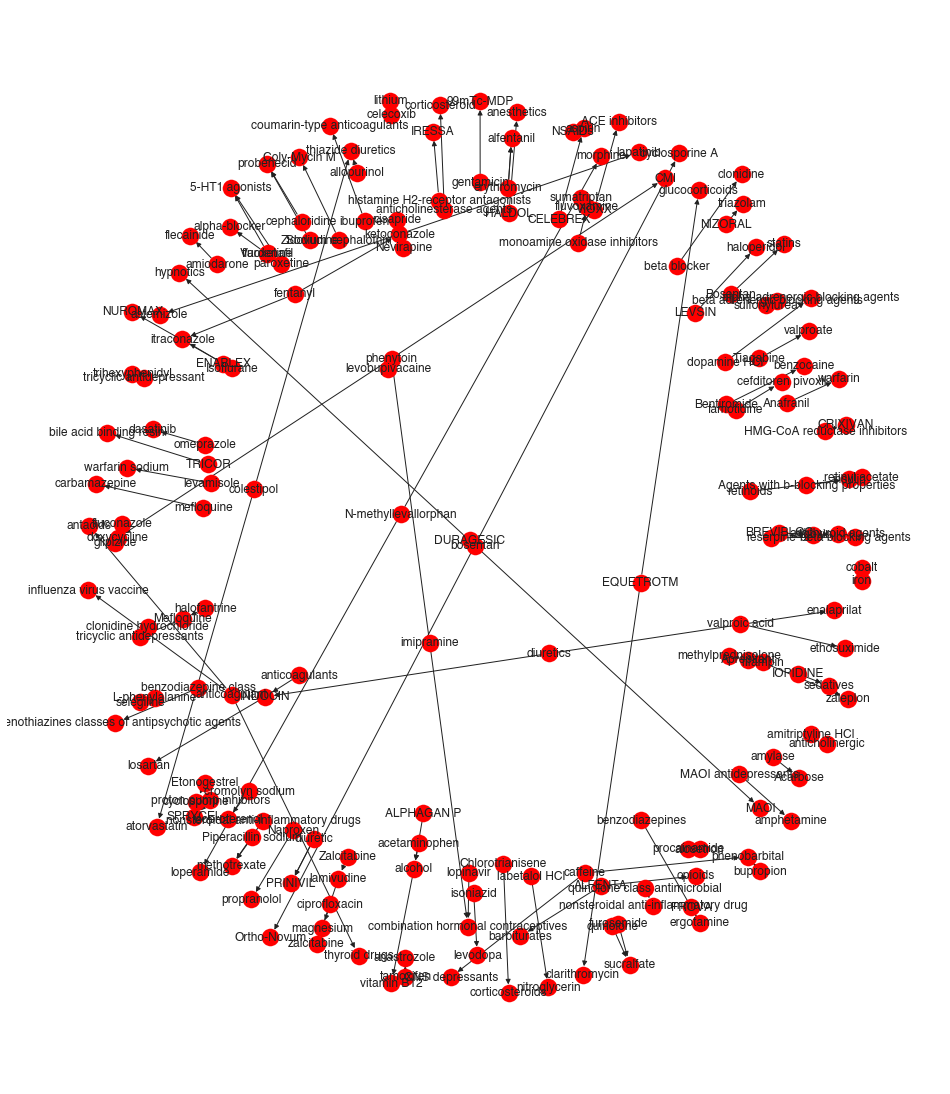

In [42]:
plt.figure(figsize=(13, 15))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()